**Network Dynamics and Learning**
# Homework III 

## 1.1 Simulate the spreading of an epidemic over a symmetric k-regular undirected graph
**Define** the graph $\mathcal{G} = (\mathcal{V, E}, W)$ where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of pairs of edges, $W$ is the weight matrix, a square matrix whose rows and colums are the indices of the nodes and its non-zero entries are the *weight* of each edge.

**Create a symmetric k-regular undirected graph.**  
To be **regular**, each graph node must have the same number of out-neighbors; to be **k-symmetric**, the number of out-neighbors is equal to $k$ and each node is linked to the nodes whose index is closest to their own modulo $n$, where $n = |\mathcal{V}|$. Finally, in an undirected graph, each link is bidirectional, as a consequence, the weight matrix is symmetric.

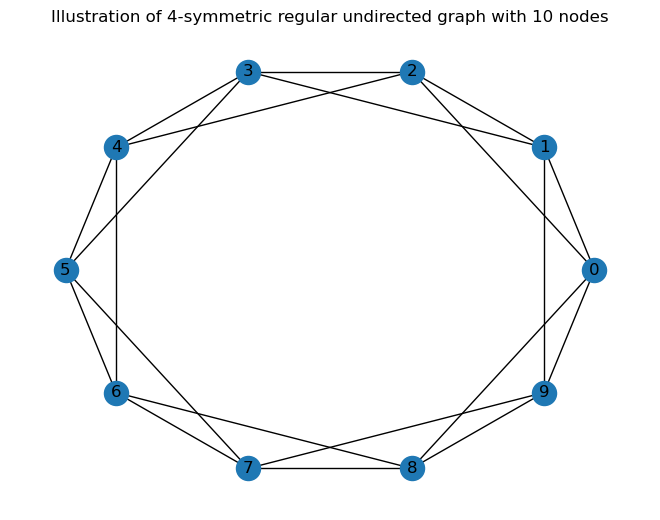

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_symmetric_regular_graph(n, k):
    assert k % 2 == 0, "k is not even, cannot be split in half"
    assert k < n, "n is smaller than k, not enough nodes to have k neighbors"
    G = nx.Graph()
    for i in range(n):
        for j in range(1, k//2 +1):
            r = i%(n-j)
            if i == r:
                G.add_edge(i, i+j)
            else:
                G.add_edge(i, r)
    return G
 

G = generate_symmetric_regular_graph(10, 4)
nx.draw_circular(G, with_labels=True)
plt.title("Illustration of 4-symmetric regular undirected graph with 10 nodes")
plt.show()

**Simulate the spreading of an epidemic over a graph.**   
In this setting, the graph nodes represent agents and the edges represent relationships between them; for instance, a link between agent *i* and agent *j* means that they are in contact with each other. 

Each agent *i* has a state $X_i(t)$ at time t. The possible states are *susceptible*, *infected* and *recovered* or *removed*, respectively states $\{S, I, R\}$. If agent *j* is infected and is linked to node *i* which is susceptible, the infection may spread to *i*, becoming infected as well. If agent *j* eventually recovers, she cannot spread the infection anymore nor can she become infected again. A susceptible agent may not evolve to the infected state unless she meets an infected one. 

The probability for the susceptible agent *i* to get infected meeting the infected agent *j* in one time-unit is $\beta$:
$$\mathbb{P}(X_i(t+1) = I | X_i(t) = S, X_j(t) = I, W_{ji} = 1 ) = \beta$$ 
where $W_{ji}$ is the weight matrix entry for the edge $(j,i)$; since W is symmetric, $W_{ij} = W_{ji}$.

Assuming that spreading the infection from one infected agent to one of its neighbors is an independent event, the probability that agent *i* gets infected is proportional to the number of infected neighbors $m$:
$$\mathbb{P}(X_i(t+1) = I | X_i(t) = S, \sum_{j \in \mathcal{V}}W_{ij}\delta_{X_j(t)}^I = m) = 1 - (1 - \beta)^m $$ 
where $\mathcal{V}$ is the set of nodes of the given graph, $\delta_{X_j(t)}^I$ is the (generalized) Kronecker delta that assumes value one when $ X_j(t) = I $, zero otherwise.

The probability that an infected agent spontaneously recovers in one time unit is $\rho$:
$$\mathbb{P}(X_i(t+1) = R | X_i(t) = I) = \rho$$

In this simple simulation of epidemic, the spreding of the infections is in discrete time, and a time-unit is a week-time. 
 
A draft of the algorithm:

The algorithm is implemented via the Numpy API.

In [2]:
import numpy as np
from time import time
def simulate_epidemic(W, beta=0.3, rho=0.7, n_infected=10, n_weeks=15, N=100):
    """
    Parameters:
        W: (2d array) graph weight matrix
        beta: (float) probability to get infected
        rho: (float) probability to recover
        n_infected: (integer) number of starting infected nodes
        n_weeks: (integer) lasting time of a single simulation
        N: (integer) number of simulation to run
    Returns:
        states: (3d array) a record of the states of the graph agents;
            its shape is (N, n_weeks, n_nodes)
        infections: (2d array) a counter of the new infections occurred
            in a time-unit; its shape is (N, n_weeks)
    """
    
    n_nodes = len(W)
    states = np.zeros((N, n_weeks, n_nodes), dtype=np.int8)
    infections = np.zeros((N, n_weeks))
    rng = np.random.default_rng()
    since = time()
    for i in range(N):
        infected = rng.choice(np.arange(n_nodes), replace=False, size=n_infected)
        infections[i, 0] = n_infected
        states[i, 0, infected] = 1
        for t in range(1, n_weeks):
            states[i, t] = states[i, t-1]
            susceptible = np.where(states[i, t-1] == 0)[0]
            infected = np.where(states[i, t-1] == 1)[0]
            for agent in susceptible:
                neighbors = np.nonzero(W[agent])[0]
                # modulo operation is faster than comparison
                # m = sum(states[i, t, neighbors] == 1)
                m = sum(states[i, t-1, neighbors] % 2)
                if m != 0:
                    p = 1 - (1-beta)**m
                    new_state = rng.choice([0, 1], p=[1-p, p])
                    if new_state:
                        infections[i, t] += 1
                    states[i, t, agent] = new_state
            for agent in infected:
                states[i, t, agent] = rng.choice([1, 2], p=[1-rho, rho])
    print("simulation time {:.2f} s".format(time() - since))
    return states, infections

In [3]:
# GRAPH PARAMETERS
n_nodes = 500
n_neighbors = 4

# EPIDEMIC PARAMETERS
beta, rho = 0.3, 0.7
n_infected = 10 # number of nodes starting the infections

# SIMULATION PARAMETERS
N = 100
n_weeks = 15

# GENERATE THE GRAPH
G = generate_symmetric_regular_graph(n_nodes, n_neighbors)
# to_numpy_array() function returns the weight matrix W of the graph G
# as a Numpy array
W = nx.to_numpy_array(G)
# exploting that W entries are either 1 o 0, the array type is 8 bit integer
# to enhance the computational efficiency
W = np.array(W, dtype=np.int8)

# SIMULATE THE EPIDEMIC
states, infections = simulate_epidemic(W, beta=0.3, rho=0.7, 
                                       n_infected=10, n_weeks=15, N=100)

simulation time 2.75 s


To see the results, we plot the average number of newly infected agents each week and the average number of susceptible, infected and recovered agents each week. We can compute the averages as the simulation has been run for 100 times.  

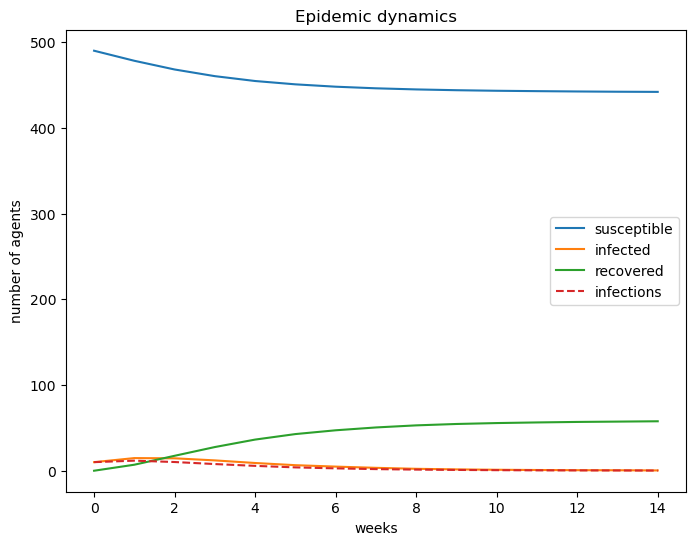

In [4]:
import matplotlib.pyplot as plt
def plot_epidemic(ax, states, infections):
    n_weeks = infections.shape[1]
    
    # weekly susceptible, infected and recovered
    S = np.sum(np.asarray(states==0), axis=2)
    I = np.sum(np.asarray(states==1), axis=2)
    R = np.sum(np.asarray(states==2), axis=2)

    ax.plot(np.arange(n_weeks), np.mean(S, axis=0), label='susceptible')
    ax.plot(np.arange(n_weeks), np.mean(I, axis=0), label='infected')
    ax.plot(np.arange(n_weeks), np.mean(R, axis=0), label='recovered')
    ax.plot(np.arange(n_weeks), np.mean(infections, axis=0), label='infections', 
            ls='--')
    ax.set_xlabel('weeks')
    ax.set_ylabel('number of agents')
    ax.set_title("Epidemic dynamics")
    ax.legend()
    return ax

fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_epidemic(ax, states, infections)
plt.show()

Looking at the plotted curves we see that the epidemic struggles to spread over. The rate of infections is too low compared to the rate of recovery to stand a chance for the epidemic to reach to the majority of agents; the number of neighbors is low as well. Thus the most of the agents never encounters an infected agent.

## 1.2 Generate a preferential attachment random graph
The preferential attachment is a graph built iteratively. Each time a new node is added to the graph, its neighbors are sampled from the probability distribution of the node degrees. Given an unweighted graph $\mathcal{G} = (\mathcal{V, E}, W)$, the probability that node *t* is linked to node *i* is:
$$
\mathbb{P}(W_{it}(t) = W_{ti}(t) = 1 | \mathcal{G}_{t-1} = (\mathcal{V}_{t-1}, \mathcal{E}_{t-1})) = \frac{w_i(t-1)}{\sum_{j\in \mathcal{V}_t-1}w_j(t-1)}
$$

In this setting, the number of neighbors of a new node $c$ is constant. The starting graph $\mathcal{G}(t=0)$ is $k_0$-complete, where $k_0 = k+1$ and $k$ is the average degree in the graph. Since the graph is undirected, $c = k / 2$. If $k$ is odd, $c$ will alternate between $c = \lfloor k / 2 \rfloor$ and $c = \lceil k/2 \rceil$

In [5]:
import networkx as nx
import numpy as np

def pa_weight_matrix(n_nodes, k):
    """
    parameters:
        n_nodes: (integer) graph nodes
        k : (interger) average node degree
    return:
        W: (2-d array) weight matrix of a preferential attachment
    """
    assert isinstance(k, int) and k > 0, "k is not integer or positive"
    rng = np.random.default_rng()
    # initial complete graph
    K = np.array(np.ones((k+1,k+1)) - np.diag(np.ones(k+1)), dtype=np.int8)
    # number of undirected
    c = int(np.floor(k/2))
    W = np.zeros((n_nodes, n_nodes), dtype=np.int8)
    W[:k+1, :k+1] = K
    for t in range(k+1,n_nodes):
        if k % 2:
            i = t % 2
        else:
            i = 0
        degrees = np.sum(W[:t, :t], axis=0)
        prob = degrees / np.sum(degrees)
        neighbors = rng.choice(np.arange(t), size=c+i, replace=False, p=prob)
        W[t][neighbors], W[:, t][neighbors] = 1, 1

    return W

An illustration of the preferential attachment iterative process. 

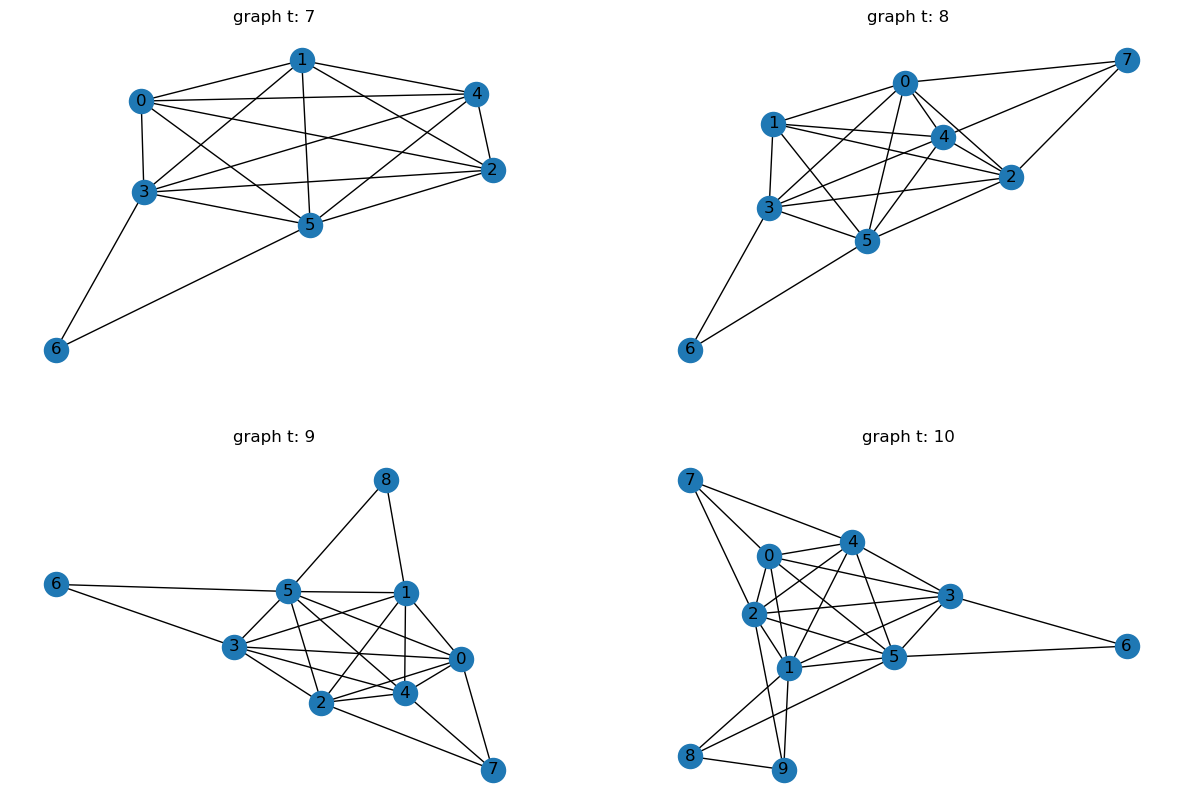

In [6]:
n, k = 10, 5
W = pa_weight_matrix(n, k)
fig = plt.figure(figsize=(15,10))
for t in range(k+1, n):
    plt.subplot(2, 2,t-k)
    G = nx.from_numpy_array(W[:t+1, :t+1])
    nx.draw(G, with_labels=True)
    plt.title('graph t: {0}'.format(t+1))

average degree: 6.0


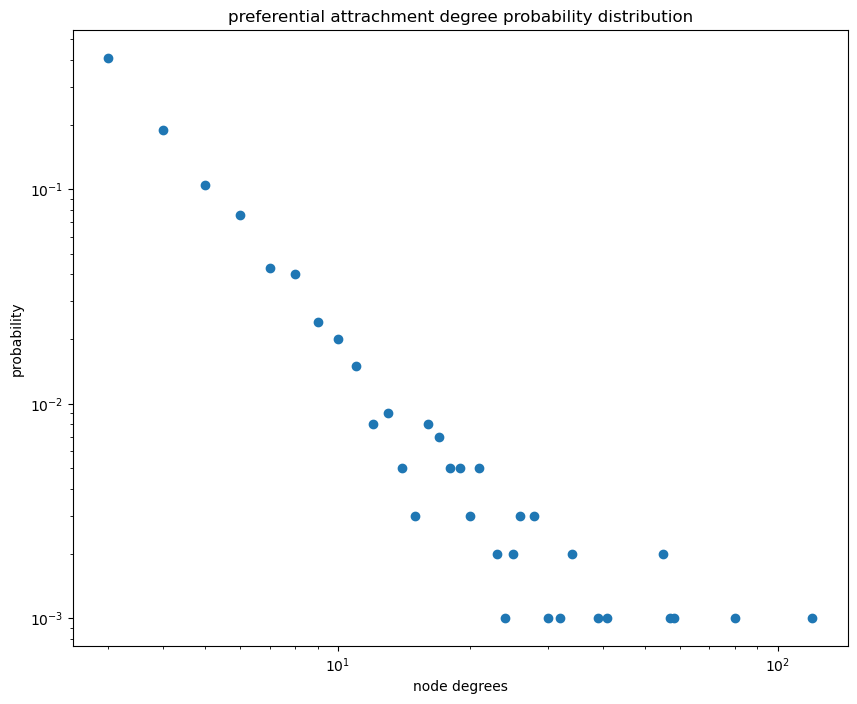

In [7]:
# plot the degree distribution
from collections import Counter
n = 1000 # number of nodes
k = 6 # average degree
W = pa_weight_matrix(n, k)
degrees = np.sum(W, axis=0)
average = np.mean(degrees)
print("average degree: {}".format(average))
counter = Counter(np.sort(degrees))
degrees = list(deg for deg in counter.values())
degrees = np.array(degrees)
degree_distr = degrees / np.sum(degrees)
plt.figure(figsize=(10, 8))
plt.scatter(counter.keys(), degree_distr)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("node degrees")
plt.ylabel("probability")
plt.title("preferential attrachment degree probability distribution")
plt.show()

We can clearly see from the graph above that the algorithm that implements the preferential attachment model complies with the feature that the graph degree distribution converges to $k^{-3}$, where k is degree of a node.

## 2. Simulate an epidemic without vaccination
We simulate the epidemic over the preferential attachment random graph with the methods previously implemented. 

There are two possible methods, either we generate a new random graph for each simulation, either we generate the graph once and run N simulation over the same graph. 
In this latter case, we would implicitly assume that the population graph is known. This assumption piles on other two: the agents do not meet new agents during the simulation besides their initial neigbors, and the structure of the graph is well estimated by the preferential attachment model. 

On the other hand, the variables of interests are the amounts of susceptible, infected individuals and the new infections; these are mostly influenced by the average degee rather than the specific set of neighbors a node might have, entailing that changing the random graph at each new simulation should not change the means of susceptible and infected individual. 

To dispel any doubt, we can set an A/B test:   
    A) generate a new random graph for each new simulation  
    B) use the same random graph for every simulation
If they differ, we will prefer method A, otherwise we will use method B for the next experiments.

In [8]:
# TEST A HYPOTHESES 
import numpy as np
from time import time
def simulate_epidemic_A(n_nodes, average_degree, beta, rho, n_infected, n_weeks, N):
    """
    Parameters:
        n_nodes : (int) number of nodes of the graph
        average_degree : (int) average degree of the graph nodes
        beta: (float) probability to get infected
        rho: (float) probability to recover
        n_infected: (integer) number of starting infected nodes
        n_weeks: (integer) lasting time of a single simulation
        N: (integer) number of simulation to run
    Returns:
        states: (3d array) a record of the states of the graph agents;
            its shape is (N, n_weeks, n_nodes)
        infections: (2d array) a counter of the new infections occurred
            in a time-unit; its shape is (N, n_weeks)
    """
    
    states = np.zeros((N, n_weeks, n_nodes), dtype=np.int8)
    infections = np.zeros((N, n_weeks))
    rng = np.random.default_rng()
    since = time()
    for i in range(N):
        W = pa_weight_matrix(n_nodes, average_degree)
        infected = rng.choice(np.arange(n_nodes), replace=False, size=n_infected)
        infections[i, 0] = n_infected
        states[i, 0, infected] = 1
        for t in range(1, n_weeks):
            states[i, t] = states[i, t-1]
            susceptible = np.where(states[i, t-1] == 0)[0]
            infected = np.where(states[i, t-1] == 1)[0]
            for agent in susceptible:
                neighbors = np.nonzero(W[agent])[0]
                m = sum(states[i, t-1, neighbors] % 2)
                if m != 0:
                    p = 1 - (1-beta)**m
                    new_state = rng.choice([0, 1], p=[1-p, p])
                    if new_state:
                        infections[i, t] += 1
                    states[i, t, agent] = new_state
            for agent in infected:
                states[i, t, agent] = rng.choice([1, 2], p=[1-rho, rho])
    print("simulation time {:.2f} s".format(time() - since))
    return states, infections

Running test A
simulation time 6.37 s
Running test B
simulation time 2.32 s


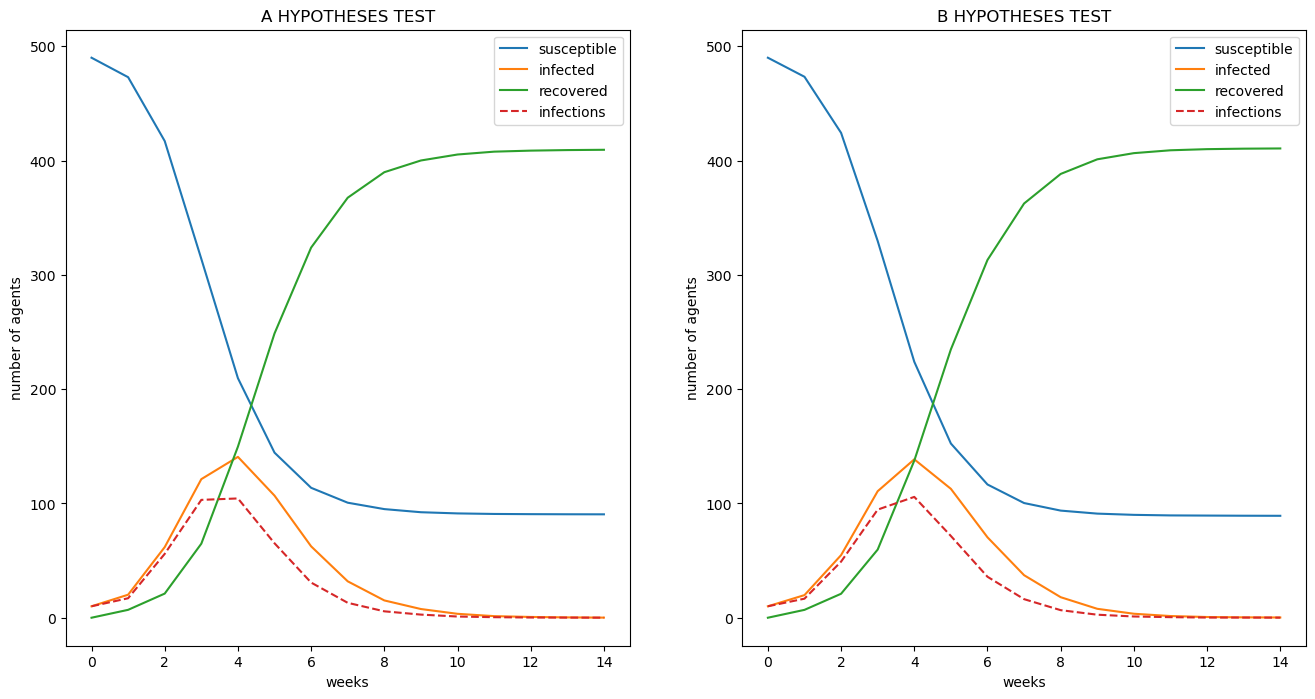

In [9]:
# GRAPH PARAMETERS
n_nodes = 500
average_degree = 6

# EPIDEMIC PARAMTERS
beta, rho = 0.3, 0.7
n_infected = 10

# SIMULATION PARAMETERS
n_weeks = 15
N = 100

# TEST A HYPOTHESES
print("Running test A")
states_A, infections_A = simulate_epidemic_A(n_nodes, average_degree,
                                             beta, rho, n_infected, 
                                             n_weeks, N)
# TEST B HYPOTHESES
print("Running test B")
W = pa_weight_matrix(n_nodes, average_degree)
states_B, infections_B = simulate_epidemic(W, beta, rho, n_infected, 
                                             n_weeks, N)

# PLOT RESULTS
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0] = plot_epidemic(ax[0], states_A, infections_A)
ax[0].set_title("A HYPOTHESES TEST")

ax[1] = plot_epidemic(ax[1], states_B, infections_B)
ax[1].set_title("B HYPOTHESES TEST")
plt.show()

Comparing the graphs we see that using the same random graph does not change the dynamics of the epidemics and it spares some computational time as well. 

We will employ method B from so on.

## Simulate an epidemic with vaccinations
In addition to the previous steps, we simulate the vaccination of agents. The input parameter of such event is the cumulative percentage of population to vaccinate during a time unit; we call this paramter `cum_vax`. The people to vaccinate are drawn from the entire population uniformly at random, regardless of their current state *S*, *I* or *R*. 

The argument `cum_vax` is added to the previous functions.

In [10]:
import numpy as np

# utility function 
# compute the exact number of people to vaccinate each week 
# given the cumulative percentage of population to vaccinate
def compute_vax(cum_vax, pop):
    """
    Parameters:
        cum_vax : (integer list) cumulative percentage of people 
            to vaccinate each week
        pop : (positive integer number) number of agents of the population
    Returns:
        vax : (1d array) number of pleople to vaccinate each week
    """
    n_weeks = len(cum_vax)
    cum_vax = list(perc / 100 for perc in cum_vax)
    vax = [0] * n_weeks
    n = cum_vax[0] * pop
    r = 1 - n % 1 
    vax[0] = np.floor(n)
    for t in range(1, n_weeks):
        n = (cum_vax[t] - cum_vax[t-1]) * pop
        r += n % 1
        if r >= 1:
            vax[t] = n // 1 + 1
            r = r - 1
        else:
            vax[t] = n  // 1
    return np.array(vax, dtype=np.int64)

In [11]:
import numpy as np
from time import time

def simulate_epidemic(W, beta, rho, n_infected, 
                      n_weeks, N,
                      cum_vax=None):
    """
    Parameters:
         W: (2d array) graph weight matrix
        beta : (float) probability to get infected
        rho : (float) probability to recover
        n_infected : (integer) number of starting infected nodes
        n_weeks : (integer) lasting time of a single simulation
        N : (integer) number of simulation to run
        cum_vax : (list of integers) cumulative percentage of people 
            to vaccinate each week
    Returns:
        states : (3d array) a record of the states of the graph agents;
            its shape is (N, n_weeks, n_nodes)
        infections : (2d array) a counter of the new infections occurred
            in a time-unit; its shape is (N, n_weeks)
        vaccinations : (1d array) a counter of the new vaccinations occurred
            in a time-unit; its shape is (n_weeks)
    """
    n_nodes = len(W)
    states = np.zeros((N, n_weeks, n_nodes), dtype=np.int8)
    infections = np.zeros((N, n_weeks))
    if cum_vax is not None: 
        vaccinations = compute_vax(cum_vax, n_nodes)
    rng = np.random.default_rng()
    since = time()
    
    for i in range(N):
        infected = rng.choice(np.arange(n_nodes), replace=False, size=n_infected)
        infections[i, 0] = n_infected
        states[i, 0, infected] = 1
        if cum_vax is not None:
            vax_states = np.ones(n_nodes, dtype=np.int8)
            to_vax = np.arange(n_nodes)
            if vaccinations[0]:
                vaccinated = rng.choice(to_vax, replace=False, size=vaccinations[0])
                states[i, 0, vaccinated] = 4
                vax_states[vaccinated] = 0
                to_vax = np.nonzero(vax_states)[0]
        for t in range(1, n_weeks):
            states[i, t] = states[i, t-1]
            susceptible = np.where(states[i, t-1] == 0)[0]
            infected = np.where(states[i, t-1] == 1)[0]
            for agent in susceptible:
                neighbors = np.nonzero(W[agent])[0]
                m = sum(states[i, t-1, neighbors] % 2)
                if m != 0:
                    p = 1 - (1-beta)**m
                    new_state = rng.choice([0, 1], p=[1-p, p])
                    if new_state:
                        infections[i, t] += 1
                    states[i, t, agent] = new_state
            for agent in infected:
                states[i, t, agent] = rng.choice([1, 2], p=[1-rho, rho])
            if cum_vax is not None:
                if vaccinations[t]:
                    vaccinated = rng.choice(to_vax, replace=False, 
                                            size=vaccinations[t])
                    states[i, t, vaccinated] = 4
                    vax_states[vaccinated] = 0
                    to_vax = np.nonzero(vax_states)[0]
#     print("simulation time {:.2f} s".format(time() - since))
    if cum_vax is not None:
        return states, infections, vaccinations
    else:
        return states, infections

In [12]:
import matplotlib.pyplot as plt
def plot_epidemic(ax, states, infections, vaccinations=None):
    n_weeks = infections.shape[1]
    
    # weekly susceptible, infected and recovered
    S = np.sum(np.asarray(states==0), axis=2)
    I = np.sum(np.asarray(states==1), axis=2)
    R = np.sum(np.asarray(states==2), axis=2)

    ax.plot(np.arange(n_weeks), np.mean(S, axis=0), label='susceptible')
    ax.plot(np.arange(n_weeks), np.mean(I, axis=0), label='infected')
    ax.plot(np.arange(n_weeks), np.mean(R, axis=0), label='recovered')
    if vaccinations is not None:
        ax.plot(np.arange(n_weeks), np.cumsum(vaccinations), label="vaccinated")
    ax.plot(np.arange(n_weeks), np.mean(infections, axis=0), label='infections', 
            ls='--')
    if vaccinations is not None:
        ax.plot(np.arange(n_weeks), vaccinations, label="vaccinations", ls ='--')
    ax.set_xlabel('weeks')
    ax.set_ylabel('number of people')
    ax.legend()
    return ax

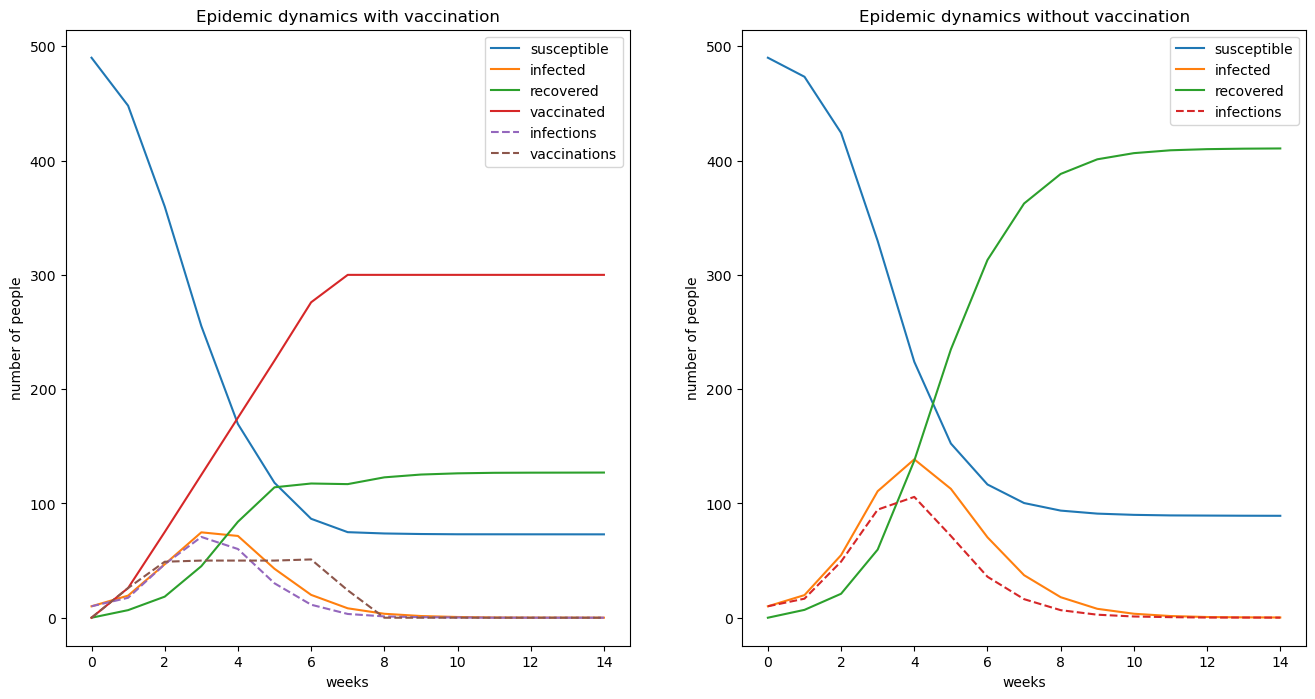

In [13]:
# GRAPH PARAMETERS
n_nodes = 500
average_degree = 6

# EPIDEMIC PARAMTERS
beta, rho = 0.3, 0.7
n_infected = 10
cum_vax = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

# SIMULATION PARAMETERS
n_weeks = 15
N = 100

W = pa_weight_matrix(n_nodes, average_degree)
states, infections, vax = simulate_epidemic(W, beta, rho, n_infected, 
                                            n_weeks, N, 
                                            cum_vax)
# plot_epidemic(states, infections)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0] = plot_epidemic(ax[0], states, infections, vax)
ax[1] = plot_epidemic(ax[1], states_B, infections_B)
ax[0].set_title("Epidemic dynamics with vaccination")
ax[1].set_title("Epidemic dynamics without vaccination")
plt.show()

We see from the graph that vaccinating the majority of the agents has a big impact on the epidemic dyamics: 
* flattens the curve of infections
* the number recovered agents is significantly lower
* the number of susceptile is slightly higher, but this is becuase the number of people 

## The H1N1 pandemic in Sweden 2009
The purpose is to find estimes of the paramters of the H1N1 pandemic occurred in Sweden in late 2009. 
The pandemic data are the following:
* the number of infected individuals from week 42, 2009 and week 5, 2010
$$ I_0(t) = [ 1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0 ]$$
* the cumulative percentage of vaccianated population
$$ vacc(t) = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] $$ 
* the number of agents $ |\mathcal{V}| = 934 $

The parameters to estimate are:
* $k_0$, the average degree of the nodes of preferential attachment graph
* $\beta_0$, the probability of getting infected
* $\rho_0$, the probability of recovery from the infection

The scoring function used to evaluate the goodness of the estimates is the root-mean-squared-error (RMSE) where $I_0$ is the ground-truth vector:
$$ RMSE(I(t)) = \sqrt{\frac{1}{n}\sum_{t=1}^n(I(t) - I_0(t))^2} $$
where $I(t)$ is the predicted number of infections, $n$ is the number of weeks. 

**Algorithm**  
for each set of parameters $(k, \beta, \rho)$ in the parameter-space $k \in \{k_0 - \Delta k, k_0, k_0 + \Delta k  \} $, $\beta \in \{\beta_0 - \Delta \beta, \beta_0, \beta_0 + \Delta \beta  \} $, $\rho \in \{\rho_0 - \Delta \rho, \rho_0, \rho_0 + \Delta \rho \} $:
1. generate a prefential attachment random graph
2. simulate the pandemic N = 10 times
3. compute the RMSE  

update $k_0, \beta_0, \rho_0$ to the set of parameters resulting in the lowest RMSE. Stop the algorithm if the returned set of paramters are equal to the one in input or if the number of iteration ecceeds a given threshold. 

After running a few experiments the best starting parameters so far are:
$$ 
\begin{alignat*}{3}
k_0 &= 9, \quad && \Delta k = 1  \\
\beta_0 &= 0.2, \quad &&  \Delta \beta = 0.01  \\
\rho_0 &= 0.775, \quad &&  \Delta \rho = 0.01
\end{alignat*}
$$

In [ ]:
# IMPORT
from sklearn.model_selection import ParameterGrid
import numpy as np
from sklearn.metrics import mean_squared_error

# CONSTANT PARAMETERS
n_nodes = 934
I_true = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0] 
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
n_infected = 1
n_weeks = len(vacc)
N = 10

# INITIAL PARAMETERS
# k, beta, rho = 10, 0.3, .7 old parameters
# k, beta, rho = 9, 0.2, .8 old paramters
# k, beta, rho = 10, 0.2, .8 previous attempts
k, beta, rho = 9, 0.2, .775
# delta_k, delta_beta, delta_rho = 1, .1, .1 old deltas 
# delta_k, delta_beta, delta_rho = 1, .05, .05 old deltas
# delta_k, delta_beta, delta_rho = 1, .025, .025 old deltas
delta_k, delta_beta, delta_rho = 1, .01, .01

grid = {'k' : [k-delta_k, k, k+delta_k], 
        'beta' : [beta-delta_beta, beta, beta+delta_beta], 
        'rho' : [rho-delta_rho, rho, rho+delta_rho]}

# grid = {'k': [k], 'beta':[beta], 'rho':[rho]}

best_params = [0, 0, 0]
best_rmse = 100
record = {}
it = 0
while [k, beta, rho] != best_params and it < 10:
    print("iteration", it)
    for params in ParameterGrid(grid):
        W = pa_weight_matrix(n_nodes, params['k'])
        states, infections, vax = simulate_epidemic(W, params['beta'], 
                                                params['rho'], 
                                                n_infected,
                                                n_weeks, N, vacc)
        rmse = mean_squared_error(I_true, np.mean(infections, axis=0), squared=False)
        if rmse < best_rmse:
            print("NEW BEST RMSE: from {:.4f} to {:.4f}".format(best_rmse, rmse))
            print("k: {}, beta: {:.2f}, rho: {:.2f}".format(
                params['k'], params['beta'], params['rho'], rmse))
            record['params'] = params
            record['states'] = states
            record['infections'] = infections
            record['vaccinations'] = vax
            record['rmse'] = rmse
            best_params = [params['k'], params['beta'], params['rho']]
            best_rmse = rmse 
    it += 1

iteration 0
NEW BEST RMSE: from 100.0000 to 7.0598
k: 8, beta: 0.19, rho: 0.77
NEW BEST RMSE: from 7.0598 to 6.0765
k: 9, beta: 0.19, rho: 0.77
NEW BEST RMSE: from 6.0765 to 4.7226
k: 9, beta: 0.20, rho: 0.77
iteration 1
iteration 2
NEW BEST RMSE: from 4.7226 to 4.2313
k: 8, beta: 0.19, rho: 0.77
iteration 3


To better analyze and understand the estimation, we will plot the ground truth vector of the number of infections, $I_0(t)$ and the estimated one, $I(t)$. To the latter, we will compute the 95% confidence interval to visualize the variance of the process.

In [ ]:
# PLOT BEST RESULT
from scipy.stats import norm

par = record['params']
print(" best RMSE: {:.4f}, k: {}, beta: {:.3f}, rho: {:.3f}".format(
        record['rmse'], par['k'], par['beta'], par['rho']))
fig, ax = plt.subplots(1,2, figsize=(16, 8))

ax[0] = plot_epidemic(ax[0], record['states'],
                      record['infections'],
                      record['vaccinations'])
ax[0].set_title("H1N1 pandemic dynamics simulation")

mean_I = np.mean(record['infections'], axis=0)
std_I = np.std(record['infections'], axis=0)
sup_ci = mean_I + norm.ppf(.975) * std_I / np.sqrt(len(mean_I))
inf_ci = mean_I - norm.ppf(.975) * std_I / np.sqrt(len(mean_I))
ax[1].plot(np.arange(n_weeks), I_true, label="I true")
ax[1].plot(np.arange(n_weeks), mean_I, label='I pred')
ax[1].fill_between(np.arange(n_weeks), sup_ci, inf_ci, color='orange', alpha=.2)
ax[1].set_xlabel('weeks')
ax[1].set_ylabel("number of people")
ax[1].set_title("ground truth and predicted number of infections")
ax[1].legend()
plt.show()

In the figure on the left we can see the H1N1 pandemic dynamics. The vaccination campaign has been effective in flattening the infection curve. 

On the right we compare the actual number of infection $I_0(t)$ and the predicted number on infection $I(t)$ to which has been computed the 95% confidence interval.
As we can see, on the peak of the infection curve the variance is very wide. This implies that the estimates yielded by the simulation process are plausible but the uncertainty remains high.  